In [35]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

import astropy.cosmology as cosmo
import astropy.units as u
import astropy.constants as const

from astropy.table import Table

from sedpy.observate import load_filters

import os

In [150]:
@u.quantity_input
def convert_janksy_to_maggies(flux_jy: u.Jy):
    flux_maggie = (flux_jy / (3631 * u.Jy)).decompose().value
    return flux_maggie

def load_prism_data(dir_name, name, version, extra_nod, units):

    # Open file
    file_name = f'{name}_prism_clear_v{version:.1f}_{extra_nod}_1D.fits'
    file_path = os.path.join(dir_name, file_name)
    hdu = fits.open(file_path)

    # Access spectral data
    wave = hdu['WAVELENGTH'].data
    flux = hdu['DATA'].data
    err = hdu['ERR'].data

    # Assign units
    wave = wave * u.m
    flux = flux * u.Unit('W / m3')
    err = err * u.Unit('W / m3')

    # Convert units
    if units == 'original':
        pass
    elif units == 'cgs':
        wave = wave.to(u.um)
        flux = flux.to(u.erg/(u.s * u.cm**2 * u.AA))
        err = err.to(u.erg/(u.s * u.cm**2 * u.AA))
    elif units == 'jy':
        wave = wave.to(u.um)
        # flux_cgs = flux.to(u.erg/(u.s * u.cm**2 * u.AA))
        # err_cgs = err.to(u.erg/(u.s * u.cm**2 * u.AA))
        # flux = flux_cgs.to(u.Jy)
        # err = err_cgs.to(u.Jy)
        flux = flux.to(u.Jy, equivalencies=u.spectral_density(wave))
        err = err.to(u.Jy, equivalencies=u.spectral_density(wave))
    elif units == 'maggies':
        wave = wave.to(u.AA)
        flux_jy = flux.to(u.Jy, equivalencies=u.spectral_density(wave))
        err_jy = err.to(u.Jy, equivalencies=u.spectral_density(wave))
        flux = convert_janksy_to_maggies(flux_jy)
        err = convert_janksy_to_maggies(err_jy)

    return wave, flux, err

In [151]:
# Load prism data
dir_name = '/Users/Jonah/PhD/Research/quiescent_galaxies/data_processed/turner+25_example'
name = '007329'
version = 3.1
# name = '013079'
# version = 1.1
extra_nod = 'extr5'

wave_um, flux_cgs, err_cgs = load_prism_data(dir_name, name, version, extra_nod, units='cgs')
wave_A, flux_maggies, err_maggies = load_prism_data(dir_name, name, version, extra_nod, units='maggies')

# Load prism dispersion data
prism_disp_name = 'jwst_nirspec_prism_disp.fits'
prism_path = os.path.join(dir_name, prism_disp_name)
disp_tb = Table.read(prism_path)

disp_wave = disp_tb['WAVELENGTH'].data
spec_disp = disp_tb['DLDS']
spec_res = disp_tb['R'].data

/Users/Jonah/opt/anaconda3/envs/quiescent-dev/lib/python3.11/site-packages/astropy/units/core.py:2085: UnitsWarning: 'MICRONS' did not parse as fits unit: At col 0, Unit 'MICRONS' not supported by the FITS standard.  If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
  warnings.warn(msg, UnitsWarning)
/Users/Jonah/opt/anaconda3/envs/quiescent-dev/lib/python3.11/site-packages/astropy/units/core.py:2085: UnitsWarning: 'MICRONS/PIXEL' did not parse as fits unit: At col 0, Unit 'MICRONS' not supported by the FITS standard.  If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
  warnings.warn(msg, UnitsW

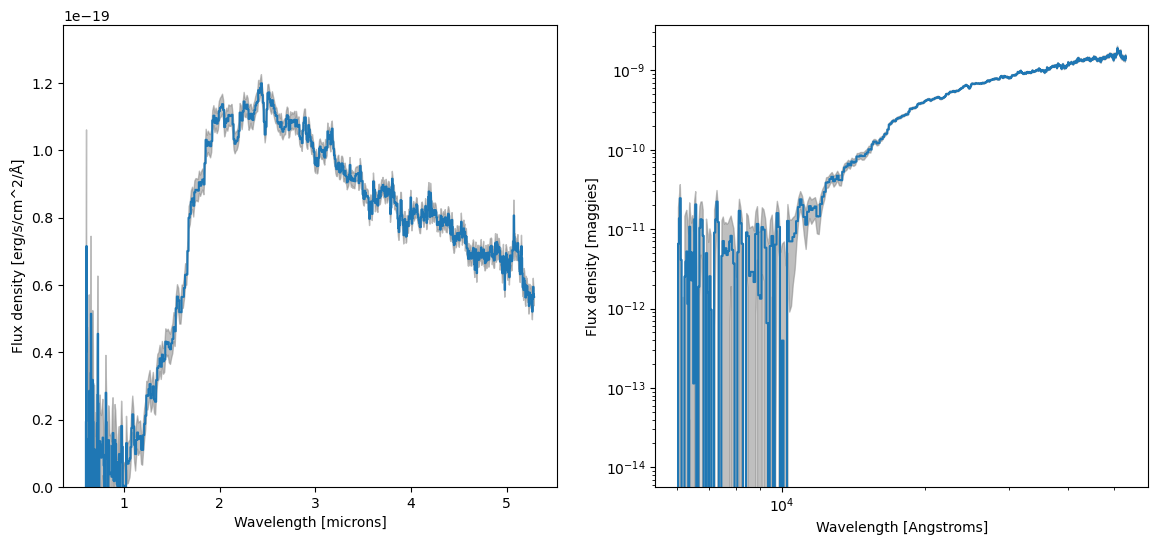

In [152]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot spectrum in cgs units
ax[0].step(wave_um, flux_cgs, where='mid')
ax[0].fill_between(wave_um.value, (flux_cgs-err_cgs).value, (flux_cgs+err_cgs).value, color='gray', alpha=0.5)
# -- prettify
ax[0].set_xlabel('Wavelength [microns]')
ax[0].set_ylabel('Flux density [erg/s/cm^2/Å]')
ax[0].set_ylim(0, None)

# Plot spectrum in maggies
ax[1].step(wave_A, flux_maggies, where='mid')
ax[1].fill_between(wave_A.value, (flux_maggies-err_maggies), (flux_maggies+err_maggies), color='gray', alpha=0.5)
# -- prettify
ax[1].set_xlabel('Wavelength [Angstroms]')
ax[1].set_ylabel('Flux density [maggies]')
# ax[1].set_ylim(0, None)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

Text(0, 0.5, 'Resolution [dimensionless]')

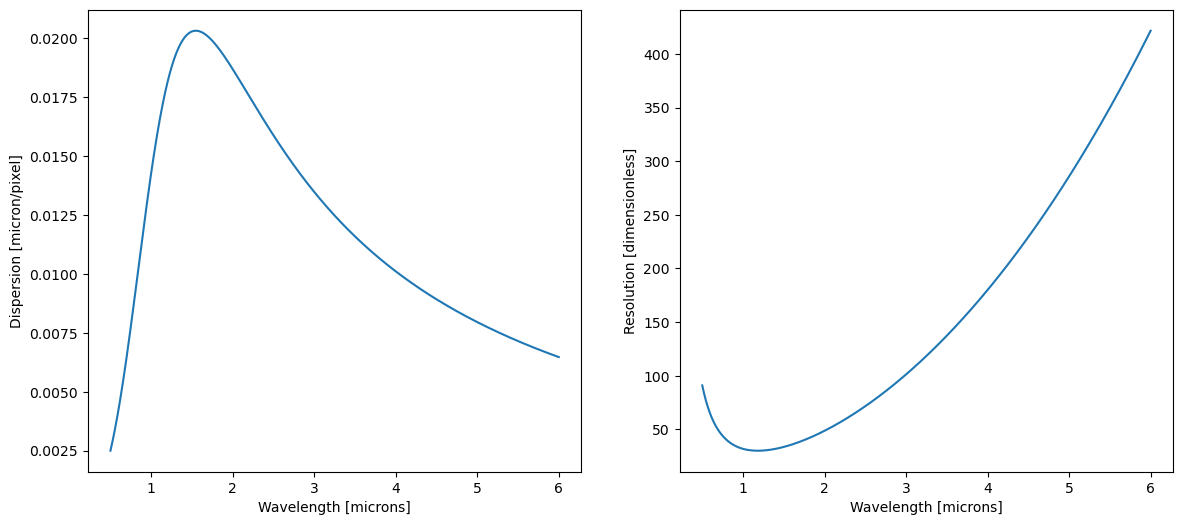

In [143]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot spectral dispersion
ax[0].plot(disp_wave, spec_dis)
ax[0].set_xlabel('Wavelength [microns]')
ax[0].set_ylabel('Dispersion [micron/pixel]')

# Plot spectral resolution
ax[1].plot(disp_wave, spec_res)
ax[1].set_xlabel('Wavelength [microns]')
ax[1].set_ylabel('Resolution [dimensionless]')